# EDA 5: Pokročilejší manipulace a agregace


Další čtení pro dlouhé večery v tomto ročním období:
* https://github.com/alanderex/pydata-pandas-workshop/tree/master/notebooks
* https://github.com/TomAugspurger/pandas-head-to-tail/blob/master/notebooks/03-Iterators-Groupby.ipynb
* https://realpython.com/pandas-groupby/

In [1]:
import pandas as pd
%matplotlib inline

## Analýza dat po skupinách

Jedním ze základních postupů v datové analýze je rozdělení dat do skupin, aplikace nějaké operace na jednotlivé skupiny a nakonec kombinace výsledků do vhodného datasetu. Anglicky se tento postup označuje jako *split-apply-combine*. Skupiny jsou často, byť ne nutně, definovány nějakou (kategorickou) proměnnou, např. by to mohla být barva, pohlaví nebo kontinent. Skupiny lze ale vytvářet i odvozováním, např. pomocí rozsahu nebo nebo vlastností časových řad. Oboje už jsme vlastně viděli v EDA 3, kdy jsme skupiny vytvářeli pro deštivé dny nebo jednotlivé roky.

Pojďme si to vysvětlit prakticky. Použijeme k tomu hezký dataset s údaji z amerického Kongresu, který obsahuje seznam všech mužů a žen, kteří kdy v jedné z jeho komor (Sněmovně nebo Senátu) zasedli.

In [2]:
# odkaz přímo na csv soubor na internetu
LEGISLATORS_HISTORICAL_URL_CSV = (
    "https://theunitedstates.io/congress-legislators/legislators-historical.csv"
)

In [3]:
legislators_historical = pd.read_csv(
    LEGISLATORS_HISTORICAL_URL_CSV,
    usecols=["gender", "type", "state", "party", "birthday", "first_name", "last_name"],
    parse_dates=["birthday"],
)

In [4]:
legislators_historical

,last_name,first_name,birthday,gender,type,state,party
0,Bassett,Richard,1745-04-02,M,sen,DE,Anti-Administration
1,Bland,Theodorick,1742-03-21,M,rep,VA,NaN
2,Burke,Aedanus,1743-06-16,M,rep,SC,NaN
3,Carroll,Daniel,1730-07-22,M,rep,MD,NaN
4,Clymer,George,1739-03-16,M,rep,PA,NaN
...,...,...,...,...,...,...,...
11976,Collins,Chris,1950-05-20,M,rep,NY,Republican
11977,Cummings,Elijah,1951-01-18,M,rep,MD,Democrat
11978,Hill,Katie,1987-08-25,F,rep,CA,Democrat
11979,Isakson,John,1944-12-28,M,sen,GA,Republican


### Krok 1: Split

Na rozdělení dat do skupin slouží metoda [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html?highlight=groupby#pandas.DataFrame.groupby). Nejjednodušší a možná i nejčastější použití je seskupení podle existujícího sloupce v tabulce. Třeba podle `type`, tedy u nás konkrétně podle komory: `rep` je Sněmovna reprezentatntů, `sen` je Senát.

In [5]:
legislators_historical_by_type = legislators_historical.groupby("type")
legislators_historical_by_type

Dostali jsme objekt typu [`GroupBy`](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html). Pokud vám to připomíná `DatetimeIndexResampler` z [Explorativní analýzy a statistiky jedné proměnné](https://naucse.python.cz/2020/pydata-praha-jaro/pydata/eda-univariate-timeseries/), je to velice dobrá asociace. Tato operace totiž data jen rozdělila do skupin, ještě jsme ale neřekli, co s těmi skupinami chceme dělat.

### Krok 2 + 3: Apply + Combine

Na skupiny, které jsme vytvořili pomocí `groupby`, teď můžeme aplikovat nějakou operaci. To je právě krok *apply*. Nemá pro nás moc cenu oddělovat tento krok od třetího kroku *combine*, protože když už nějakou opraci aplikujeme, tak bychom rádi výsledek sestavili do výsledného datasetu. Pandas navíc tyto kroky sám nijak neodděluje.

*Pozn.: Apply a combine začne být více odděleno v nástrojích na zpracování velkých dat, které už se nevejdou pohodlně do operační paměti počítače a pandas na ně už nestačí. Apply pak probíhá po částech, třeba i distribuovaně na oddělených serverech, a výsledné combine se provádí sesbíráním částečných výsledků.* 

Použijeme teď jednoduchou agregační metodu `count`, která nám vrátí počet hodnot (po skupinách samozřejmě).

In [6]:
legislators_historical_by_type.count()

,last_name,first_name,birthday,gender,state,party
type,,,,,,
rep,10151,10151,9658,10151,10151,9925
sen,1830,1830,1770,1830,1830,1822


Vidíme, že v datech je zaznamenáno 1830 senátorů a 10151 kongresmanů. Na levé straně v indexu vidíme skupiny, podle kterých se dataset agregoval a do sloupců se daly všechny sloupce, na které bylo možné aplikovat naši agregační funkci (v tom případě na všechny zbylé).

Z čísel si můžeš všimnout, že u některých chybí údaje o datu narození nebo straně.

Než aplikujeme krok *apply*, můžeme si vybrat, na který ze sloupců tak učiníme, trochu si tím zpřehledníme výstup. Pokud si vybereme jen jeden sloupec, dostaneme Series.

In [7]:
legislators_historical_by_type['party'].count()

type
rep    9925
sen    1822
Name: party, dtype: int64

Tento krok si můžeme trochu zjednodušit - než abychom se doptávali na `count` nad jedním sloupcem v rámci agregace, můžeme se doptat na *velikost* každé ze skupin.

In [8]:
legislators_historical_by_type.size()

type
rep    10151
sen     1830
dtype: int64

**Úkol:** Rozděl data podle strany (`party`) a vypiš počet záznamů v každé skupině. Dokážeš výsledek setřídit podle velikosti skupin? 

In [9]:
# řešení
legislators_historical.groupby("party").size().sort_values(ascending=False).head(5)

party
Democrat      5005
Republican    4881
Whig           564
Federalist     343
Jackson        338
dtype: int64

Možná sis všimla, jaký je u výsledku index. Pokud ne, nevadí, určitě si všimneš teď. Zkusíme totiž vytvořit skupiny ne z jednoho sloupce, ale ze dvou. Pojďme si rozdělit zákonodárce podle států, a každou skupinu za jeden stát ještě podle pohlaví.

In [10]:
legislators_by_state_gender_counts = legislators_historical.groupby(["state", "gender"]).count()
legislators_by_state_gender_counts

last_name  first_name  birthday  type  party
state gender                                              
AK    M              16          16        16    16     14
AL    F               3           3         3     3      3
      M             203         203       194   203    203
AR    F               5           5         5     5      5
      M             112         112       109   112    110
...                 ...         ...       ...   ...    ...
WI    M             197         197       197   197    197
WV    F               1           1         1     1      1
      M             119         119       117   119    119
WY    F               2           2         2     2      2
      M              38          38        38    38     38

[104 rows x 5 columns]

Máme tedy skupiny, které jsou definované dvojicí hodnot stát a pohlaví (`state`, `gender`). A to je přesně důvod, proč existuje v Pandas [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html).

### Práce s MultiIndex

Vlastnosti MultiIndexu, vlastně takového víceúrovňového či vícerozměrného indexu, můžeme prozkoumat (kromě prostého zobrazení) pomocí několika užitečných atributů (properties).

In [11]:
# počet úrovní 
legislators_by_state_gender_counts.index.nlevels

2

In [12]:
# jména úrovní
legislators_by_state_gender_counts.index.names

FrozenList(['state', 'gender'])

In [13]:
# mohutnost (počet hodnot) jednotlivých úrovní
legislators_by_state_gender_counts.index.levshape

(58, 2)

In [14]:
# hodnoty v jednotlivých úrovních
legislators_by_state_gender_counts.index.levels

FrozenList([['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'DK', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OL', 'OR', 'PA', 'PI', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'], ['F', 'M']])

Víme tedy, že náš (multi) index má dvě úrovně. Abychom dostali konkrétní řádek, musíme tím pádem zadat dvě hodnoty. K tomu nám poslouží `tuple` (pozor, musí to opravdu být `tuple` a ne `list`, tj. musíme použít kulaté a ne hranaté závorky).

In [15]:
legislators_by_state_gender_counts.loc[("WY", "F")]

last_name     2
first_name    2
birthday      2
type          2
party         2
Name: (WY, F), dtype: int64

Co kdybychom zadali jen polovinu indexu? Dostaneme celou skupinu, v našem případě celý stát.

In [16]:
legislators_by_state_gender_counts.loc["WY"]

,last_name,first_name,birthday,type,party
gender,,,,,
F,2,2,2,2,2
M,38,38,38,38,38


**Otázka:** Jaký je index výsledné tabulky?

Pokud bychom chtěli jedno pohlaví, můžeme indexu změnit pořadí.

In [17]:
swapped_index = legislators_by_state_gender_counts.index.swaplevel(0, 1)
legislators_by_gender_state_counts = legislators_by_state_gender_counts.set_index(swapped_index)
legislators_by_gender_state_counts

last_name  first_name  birthday  type  party
gender state                                              
M      AK            16          16        16    16     14
F      AL             3           3         3     3      3
M      AL           203         203       194   203    203
F      AR             5           5         5     5      5
M      AR           112         112       109   112    110
...                 ...         ...       ...   ...    ...
       WI           197         197       197   197    197
F      WV             1           1         1     1      1
M      WV           119         119       117   119    119
F      WY             2           2         2     2      2
M      WY            38          38        38    38     38

[104 rows x 5 columns]

In [18]:
legislators_by_gender_state_counts.loc["F"].head()

,last_name,first_name,birthday,type,party
state,,,,,
AL,3,3,3,3,3
AR,5,5,5,5,5
AZ,3,3,3,3,3
CA,24,24,24,24,24
CO,3,3,3,3,3


Více o (pokročileší) práci s indexy a multiindexy najdeš v [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).

Pokud bychom se chtěli multiindexu "zbavit", můžeme to udělat pomocí `.reset_index()`

In [19]:
legislators_by_state_gender_counts.reset_index().head(5)

,state,gender,last_name,first_name,birthday,type,party
0,AK,M,16,16,16,16,14
1,AL,F,3,3,3,3,3
2,AL,M,203,203,194,203,203
3,AR,F,5,5,5,5,5
4,AR,M,112,112,109,112,110


Anebo rovnou použít `groupby` s `as_index=False`.

In [20]:
legislators_historical.groupby(["state", "gender"], as_index=False).count().head(5)

,state,gender,last_name,first_name,birthday,type,party
0,AK,M,16,16,16,16,14
1,AL,F,3,3,3,3,3
2,AL,M,203,203,194,203,203
3,AR,F,5,5,5,5,5
4,AR,M,112,112,109,112,110


**Úkol:** TODO

## Co je ten `DataFrameGroupBy object`?

Na začátku jsme si udělali základní agregaci bez aplikace funkcí a dostali jsme jakýsi objekt. Je možné s ním něco dělat, aniž bychom agregovali? Ukazuje se, že ano.

In [21]:
legislators_historical.groupby('state')

Jedna klíčová funkce, kterou nám tento objekt nabízí, je iterace.

In [22]:
groups = legislators_historical.groupby('state')

next(iter(groups)) # timhle ziskame prvni element pri iteraci (for cyklu)

('AK',         last_name first_name   birthday gender type state        party
 6619       Waskey      Frank 1875-04-20      M  rep    AK     Democrat
 6647         Cale     Thomas 1848-09-17      M  rep    AK  Independent
 7442      Grigsby     George 1874-12-02      M  rep    AK          NaN
 7501       Sulzer    Charles 1879-02-24      M  rep    AK          NaN
 8039   Sutherland     Daniel 1869-04-17      M  rep    AK   Republican
 8236   Wickersham      James 1857-08-24      M  rep    AK   Republican
 8877       Dimond    Anthony 1881-11-30      M  rep    AK     Democrat
 9819     Gruening     Ernest 1887-02-06      M  sen    AK     Democrat
 9951       Rivers      Ralph 1903-05-23      M  rep    AK     Democrat
 9985     Bartlett     Edward 1904-04-20      M  sen    AK     Democrat
 10082     Pollock     Howard 1920-04-11      M  rep    AK   Republican
 10108      Begich   Nicholas 1932-04-06      M  rep    AK     Democrat
 10325      Gravel    Maurice 1930-05-13      M  sen    AK

Mírná odbočka zpět k Pythonu jako takovému. Máme-li nějaký zdroj tuplů:

In [23]:
data = [('Ondřej', 29), ('Královna Alžběta', 93), ('Maggie Simpson', 1)]

Pak můžeme v rámci iterace dostat buďto celý tuple, nebo můžeme rovnou *rozbalit* jednotlivé hodnoty do proměnných

In [24]:
for element in data:
    print(element)

('Ondřej', 29)
('Královna Alžběta', 93)
('Maggie Simpson', 1)


In [25]:
for name, age in data:
    print(f'{name}: {age} let')

Ondřej: 29 let
Královna Alžběta: 93 let
Maggie Simpson: 1 let


Zpět k naší agregaci - jak nám to pomůže? Podívejte zpět na to, co jsme dostali při iteraci nad `DataFrameGroupBy` objektem?

Ano, je to tuple.

In [26]:
groups = legislators_historical.groupby('state')

next(iter(groups))

('AK',         last_name first_name   birthday gender type state        party
 6619       Waskey      Frank 1875-04-20      M  rep    AK     Democrat
 6647         Cale     Thomas 1848-09-17      M  rep    AK  Independent
 7442      Grigsby     George 1874-12-02      M  rep    AK          NaN
 7501       Sulzer    Charles 1879-02-24      M  rep    AK          NaN
 8039   Sutherland     Daniel 1869-04-17      M  rep    AK   Republican
 8236   Wickersham      James 1857-08-24      M  rep    AK   Republican
 8877       Dimond    Anthony 1881-11-30      M  rep    AK     Democrat
 9819     Gruening     Ernest 1887-02-06      M  sen    AK     Democrat
 9951       Rivers      Ralph 1903-05-23      M  rep    AK     Democrat
 9985     Bartlett     Edward 1904-04-20      M  sen    AK     Democrat
 10082     Pollock     Howard 1920-04-11      M  rep    AK   Republican
 10108      Begich   Nicholas 1932-04-06      M  rep    AK     Democrat
 10325      Gravel    Maurice 1930-05-13      M  sen    AK

Můžeme-li tedy dostat tuple při každé iteraci, můžeme jej rozbalit. Konkrétně to je dvoupoložkový tuple, kde první element je hodnota, nad kterou je agregováno, a druhý element je celý DataFrame, který této hodnotě odpovídá!

In [27]:
for index, df in groups:
    break

In [28]:
index

'AK'

In [29]:
df

,last_name,first_name,birthday,gender,type,state,party
6619,Waskey,Frank,1875-04-20,M,rep,AK,Democrat
6647,Cale,Thomas,1848-09-17,M,rep,AK,Independent
7442,Grigsby,George,1874-12-02,M,rep,AK,NaN
7501,Sulzer,Charles,1879-02-24,M,rep,AK,NaN
8039,Sutherland,Daniel,1869-04-17,M,rep,AK,Republican
8236,Wickersham,James,1857-08-24,M,rep,AK,Republican
8877,Dimond,Anthony,1881-11-30,M,rep,AK,Democrat
9819,Gruening,Ernest,1887-02-06,M,sen,AK,Democrat
9951,Rivers,Ralph,1903-05-23,M,rep,AK,Democrat
9985,Bartlett,Edward,1904-04-20,M,sen,AK,Democrat


K čemu nám to může být? Při agregaci se data drasticky zjednodušují a nemusíme si vždy být jisti, že naše agregace jsou napsané správně. Pomocí iterace nad skupinami si můžeme zobrazit všechna data před agregací.

In [30]:
import os
target_directory = 'by_states'
os.makedirs(target_directory, exist_ok=True)

for state, df in legislators_historical.groupby('state'):
    df.to_csv(os.path.join(target_directory, state + '.csv'))

## Další agregační funkce

Dosud jsme agregovali jen pomocí `.size` nebo `.count`, ale existuje spousta další agregačních metod, zejm. těch numerických.

Pro snadnější práci s agregacemi budeme používat metodu `.agg`, která akceptuje slovník. Tento slovník udává, *co* chceme agregovat (klíč) a *jak* to chceme agregovat (hodnota). S tím, že způsobů agregace pro jeden sloupec může být více naráz. Ukážeme si.

In [31]:
legislators_historical.groupby('state').agg({'birthday': 'max'}).head()

,birthday
state,
AK,1962-03-30
AL,1967-10-09
AR,1968-08-21
AS,1943-08-15
AZ,1976-11-03


In [32]:
legislators_historical.groupby('state').agg({'birthday': ['min', 'max'], 'party': 'nunique'}).head()

birthday              party
             min        max nunique
state                              
AK    1848-09-17 1962-03-30       3
AL    1780-01-30 1967-10-09       8
AR    1788-08-25 1968-08-21       5
AS    1937-03-13 1943-08-15       1
AZ    1816-01-24 1976-11-03       3

## Agregace nad nesloupci

Dosud jsme vždy agregovali nad něčím, co jsme měli v DataFramu. Je ale možné agregovat nad daty, které tam vůbec nemáme, alespoň ne explicitně.

Kromě názvu sloupce můžeme do `groupby` vložit nějakou Series (!), která má stejný tvar jako naše sloupce a pandas podle toho bude umět agregovat. Jaká taková Series se nabízí? Nejlépe transformace nějakého existujícího sloupce.

Na začátku jsme si ukazovali, že občas chybí nějaká data, konkrétně birthday a party.

In [33]:
legislators_historical.party.isnull()

0        False
1         True
2         True
3         True
4         True
         ...  
11976    False
11977    False
11978    False
11979    False
11980    False
Name: party, Length: 11981, dtype: bool

Series má metodu `isnull`, která nám vrátí True/False hodnoty podle toho, jestli daná hodnota je platná nebo ne (chybějící, NULL v SQL).

Tuto Series můžeme použít pro agregaci.

In [34]:
legislators_historical.groupby([
    legislators_historical.state,
    legislators_historical.party.isnull()]).size()

state  party
AK     False     14
       True       2
AL     False    206
AR     False    115
       True       2
               ... 
VT     True       4
WA     False     95
WI     False    197
WV     False    120
WY     False     40
Length: 91, dtype: int64

Ukázali jsme si agregaci na jednoduché metodě `.isnull`, ale na čem dalším to jde udělat?

### .str a .dt metody

Podobně jako můžeme testovat zda hodnoty existují, můžeme testovat různé vlastnosti stringů a dat (od slova datum). Slouží k tomu [.str](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods) a [.dt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html).

In [35]:
name_length = legislators_historical.first_name.str.len()
name_length

0         7
1        10
2         7
3         6
4         6
         ..
11976     5
11977     6
11978     5
11979     4
11980     6
Name: first_name, Length: 11981, dtype: int64

Často používanými metodami v rámci `.str` je `contains` nebo `.lower/upper`

In [36]:
names = pd.Series(['JOHN', 'Jean-Luc', 'Mary-Jane', 'Kate', 'John'])
names.str.contains('-')

0    False
1     True
2     True
3    False
4    False
dtype: bool

In [37]:
names[names.str.contains('-')]

1     Jean-Luc
2    Mary-Jane
dtype: object

Zatímco `.str.contains` použijeme zpravidla na filtrování, `.lower` poslouží třeba na unifikaci dat, která se pak lépe agregují (a deduplikují).

In [38]:
names.value_counts()

Kate         1
JOHN         1
John         1
Jean-Luc     1
Mary-Jane    1
dtype: int64

In [39]:
names.str.lower().value_counts()

john         2
mary-jane    1
jean-luc     1
kate         1
dtype: int64

Z `.dt` si ukážeme jak vytáhnout z data rok.

In [40]:
birth_years = legislators_historical.birthday.dt.year

birth_years#.value_counts()

0        1745.0
1        1742.0
2        1743.0
3        1730.0
4        1739.0
          ...  
11976    1950.0
11977    1951.0
11978    1987.0
11979    1944.0
11980    1976.0
Name: birthday, Length: 11981, dtype: float64

In [41]:
legislators_historical.groupby(birth_years)

### Binning

Sice jsme si vytáhli jednotlivé roky narození, ale přeci jen jich je spousta a moc nám to neřekne, určitě se podle nich nedá dobře agregovat.

In [42]:
birth_years = legislators_historical.birthday.dt.year.astype('Int16')
legislators_historical = legislators_historical.assign(birth_year=birth_years)

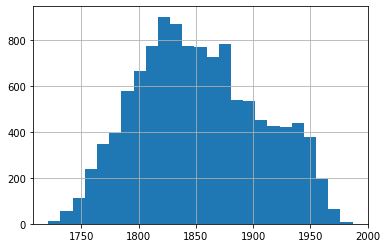

In [43]:
legislators_historical.birth_year.hist(bins=25)

In [44]:
legislators_historical.birth_year.value_counts()

1840    94
1824    94
1870    93
1828    92
1835    91
        ..
1981     1
1977     1
1721     1
1983     1
1987     1
Name: birth_year, Length: 258, dtype: Int64

Ani histogram, ani `value_counts` nám žádné moc hodnotné informace nepřinesl. Budeme muset data trochu seskupit. Na to v pandas existuje několik možností.

První z nich je nám již známý `.value_counts`, kterému můžeme přihodit argument `bins`, který znamená, že nechceme frekvence jednotlivých hodnot, ale že chceme seskupit data do několika intervalů.

In [45]:
legislators_historical.birth_year.value_counts(bins=10)

(1827.4, 1854.0]      2077
(1800.8, 1827.4]      2059
(1854.0, 1880.6]      1839
(1880.6, 1907.2]      1345
(1774.2, 1800.8]      1245
(1907.2, 1933.8]      1021
(1933.8, 1960.4]       937
(1747.6, 1774.2]       647
(1960.4, 1987.0]       145
(1720.733, 1747.6]     113
Name: birth_year, dtype: int64

Co když nám takové samorozdělení nestačí? Na to je `pandas.cut`, resp. `pd.cut`. Má spoustu možností, doporučujeme [projít dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

In [46]:
bins = [1700, 1750, 1800, 1850, 1900, 1950]
pd.cut(legislators_historical.birth_year, bins)

0        (1700.0, 1750.0]
1        (1700.0, 1750.0]
2        (1700.0, 1750.0]
3        (1700.0, 1750.0]
4        (1700.0, 1750.0]
               ...       
11976    (1900.0, 1950.0]
11977                 NaN
11978                 NaN
11979    (1900.0, 1950.0]
11980                 NaN
Name: birth_year, Length: 11981, dtype: category
Categories (5, interval[int64]): [(1700, 1750] < (1750, 1800] < (1800, 1850] < (1850, 1900] < (1900, 1950]]

In [47]:
pd.cut(legislators_historical.birth_year, bins).value_counts()

(1800, 1850]    3839
(1850, 1900]    3159
(1900, 1950]    2002
(1750, 1800]    1856
(1700, 1750]     149
Name: birth_year, dtype: int64

Nevýhodou `pd.cut` je, že intervaly jsou určeny uživatelem a může chvíli trvat, než je člověk odladí. Více automatická je možnost určit intervaly pomocí statistického rozložení dat, k tomu slouží `pd.qcut`, ten místo hranic intervalů bere kvantily.

In [48]:
pd.qcut(legislators_historical.birth_year, [0, .1, .5, .9, 1]).value_counts()

(1784.0, 1849.0]      4616
(1849.0, 1932.0]      4545
(1720.999, 1784.0]    1155
(1932.0, 1987.0]      1112
Name: birth_year, dtype: int64

### Kontingenční tabulky

Pokud budeme agregovat nad několika sloupci, může se nám stát, že z DataFramu se nám stane jedna dlouhá nudle. V tom se nedá moc dobře vyznat. Pokud jste s takovými daty někdy pracovali v Excelu, možná vám bude povědomá funkce kontigenčních tabulek, v angličtině pivot tables.

In [49]:
agg = legislators_historical.groupby(['type', 'gender'], as_index=False)[['last_name']].count()
agg = agg.rename(columns={'last_name': 'count'})
agg

,type,gender,count
0,rep,F,204
1,rep,M,9947
2,sen,F,31
3,sen,M,1799


Součástí každého `pivot`u jsou tři faktory - specifikace,

1. který se sloupců chceme v indexu
2. který bude ve sloupcích
3. který sloupec se přiřadí do hodnot v DataFramu

In [50]:
agg.pivot(index='gender', columns='type', values='count')

type,rep,sen
gender,,
F,204,31
M,9947,1799


Omezením metody `pivot` je to, že umí jen otáčet DataFrame, ale pokud některému z políček odpovídá více hodnot, vyhodí vám chybu, protože neví, jak je má agregovat. Pivot je opravdu jen pro otáčení.

Na komplexnější agregace tu je podobně pojmenovaný `pivot_table`.

In [51]:
agg = legislators_historical.groupby(['type', 'state', 'gender'], as_index=False)[['last_name']].count()
agg = agg.rename(columns={'last_name': 'count'})
agg

,type,state,gender,count
0,rep,AK,M,10
1,rep,AL,F,1
2,rep,AL,M,166
3,rep,AR,F,3
4,rep,AR,M,81
...,...,...,...,...
167,sen,VT,M,36
168,sen,WA,M,20
169,sen,WI,M,26
170,sen,WV,M,31


`pivot_table` nabízí možnost přiřadit do některé z dimenzí (do indexu či sloupců) vícero sloupců, a následně pak vytvoří víceúrovňový index. Jde též specifikovat, jaká funkce se aplikuje, pokud na buňku připadá více hodnot (jako v Excelu).

Více detailů najdete [v dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).

In [52]:
wide = agg.pivot_table(index='state', columns=['type', 'gender'], values='count', fill_value='')

wide.head(10)

type   rep        sen    
gender   F      M   F   M
state                    
AK           10.0       6
AL       1  166.0   2  37
AR       3   81.0   2  31
AS            2.0        
AZ       3   34.0      11
CA      23  298.0   1  41
CO       3   53.0      34
CT       6  183.0      51
DC            2.0        
DE           48.0      49

Kdyby ti přišlo matoucí, že tu jsou dvě podobné funkce na kontigenční tabulky, tak tě ještě víc zmateme, protože existuje ještě `pd.crosstab`. Do detailů zde už zacházet nebudeme, doporučujeme [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html).

### Inverzní kontigenční tabulky

Zatímco na kontigenční tabulky mnozí narazili, jejich inverzní funkcionalita je celkem neznámá, a zajímavá. Funguje přesně tak, jak píšeme - vezme se široká tabulka, ve které je jedna z dimenzí ve sloupcích, a zúží a prodlouží se tím, že se ony názvy sloupcí překonvertují do samotného sloupce. Příklad bude názornější.

V pandas se na tuto inverzní operaci používá metoda `melt`. Její delší výčet argumentů je tradičně [v dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html).

Mějme dataset, kde je výkon v různých regionech fiktivní země. Nevýhodou je, že nemůžeme úplně dívat na časové řady, protože roky, ke kterým údaje platí, jsou ve sloupcích, ne v řádcích. Takto široké tabulky jsou celkem populární třeba u dat o počasí.

In [53]:
df = pd.DataFrame({
    'region': ['North', 'South', 'East', 'West'],
    '2000': [200, 100, 50, 1000],
    '2005': [450, 10, 510, 1040],
    '2010': [10, 500, 950, 500],
    '2015': [550, 20, 50, 10],
    '2020': [1, 1, 5, 10],
})
df

,region,2000,2005,2010,2015,2020
0,North,200,450,10,550,1
1,South,100,10,500,20,1
2,East,50,510,950,50,5
3,West,1000,1040,500,10,10


`pd.melt` zajímá, který ze sloupců nějak identifikuje dané řádky (`id_vars`) a které sloupce obsahují hodnoty (`value_vars`). Zbylé dva argumenty slouží jen k přejmenování sloupců (`var_name`, `value_name`).

In [54]:
long = df.melt(id_vars=['region'], value_vars=['2000', '2005', '2010', '2015', '2020'],
        var_name='year', value_name='output')

long

,region,year,output
0,North,2000,200
1,South,2000,100
2,East,2000,50
3,West,2000,1000
4,North,2005,450
5,South,2005,10
6,East,2005,510
7,West,2005,1040
8,North,2010,10
9,South,2010,500


*Úkol: vem tento dlouhý dataset a udělej z něj ten původní, široký.* (Nereš, pokud máš někde index, kde před tím nebyl.)